# Giris
Yeni bir TensorFlow çalışmasından sizlere merhaba! Bu çalışmamızda, metin veri setlerinin yüklenmesi ve metin verilerinin model için uygun hale getirilmesi yöntemlerini ele alacağız.


In [350]:
!pip install tensorflow-text

In [351]:
# Kullanacagimiz Kutuphaneler
import collections
import pathlib

import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers import TextVectorization

import tensorflow_datasets as tfds
import tensorflow_text as tf_text

# Örnek 1: Bir Stack Overflow sorusu için etiketi tahmin edin
StackOverflow veri kümesini indireceğiz ve bu veri kümesinde etiketlenmiş veriler bulunmaktadır. Her soru, kodlama dillerinden oluşan kendine ait bir etikete sahiptir. Örneğin, "Bir sözlüğü değere göre nasıl sıralarım?" sorusunun etiketi "Python", "Java", "JavaScript" veya "CSharp" olabilir. Bizim buradaki görevimiz, soruların etiketini tahmin eden bir yapay zeka modeli geliştirmek.

## Veri setini indirin ve inceleyin

In [352]:
# Veri setinin indirilmesi
data_url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'

dataset_dir = utils.get_file(
    origin=data_url,
    untar=True,
    cache_dir='stack_overflow',
    cache_subdir='')

dataset_dir = pathlib.Path(dataset_dir).parent

In [353]:
list(dataset_dir.iterdir())

[PosixPath('/tmp/.keras/stack_overflow_16k.tar.gz'),
 PosixPath('/tmp/.keras/stack_overflow_16k.tar.gz_archive')]

In [354]:
sub_dir = dataset_dir / 'stack_overflow_16k.tar.gz'
list(sub_dir.iterdir())

[PosixPath('/tmp/.keras/stack_overflow_16k.tar.gz/train'),
 PosixPath('/tmp/.keras/stack_overflow_16k.tar.gz/README.md'),
 PosixPath('/tmp/.keras/stack_overflow_16k.tar.gz/test')]

In [355]:
"""import tarfile

tar_path = dataset_dir / 'stack_overflow_16k.tar.gz_archive'  # Girmek istediğiniz klasör adı

with tarfile.open(tar_path, "r:gz") as tar:
  tar.list()"""

# Yukaridaki kod blogu ile "stack_overflow_16k.tar.gz_archive" dosyasi icerisindeki gorebilirsiniz. Icerik cok fazla kodu calistirdiktan sonra biraz zaman gectikten sonra durdurun!

'import tarfile\n\ntar_path = dataset_dir / \'stack_overflow_16k.tar.gz_archive\'  # Girmek istediğiniz klasör adı\n\nwith tarfile.open(tar_path, "r:gz") as tar:\n  tar.list()'

In [356]:
# train_dir = dataset_dir/'train' ile train klasorune ulasamadim ve asagidaki cozum ile train klasorune ulastim!
train_dir = dataset_dir/'stack_overflow_16k.tar.gz/train'
list(train_dir.iterdir())

[PosixPath('/tmp/.keras/stack_overflow_16k.tar.gz/train/java'),
 PosixPath('/tmp/.keras/stack_overflow_16k.tar.gz/train/javascript'),
 PosixPath('/tmp/.keras/stack_overflow_16k.tar.gz/train/csharp'),
 PosixPath('/tmp/.keras/stack_overflow_16k.tar.gz/train/python')]

train/csharp, train/java, train/python ve train/javascript dizinleri, her biri bir Stack Overflow sorusu olan birçok metin dosyası içerir.

In [357]:
sample_file = train_dir/'python/1755.txt'
with open(sample_file) as f:
  print(f.read())

why does this blank program print true x=true.def stupid():.    x=false.stupid().print x



Python olarak etiketlenmiş verilerin 1755. metin dosyasının içeriğini inceliyoruz.

## Veri setini yükleyin
Veri setimizi disk üzerinde inceledik ve şimdi eğitime uygun hale getirme aşamalarını gerçekleştireceğiz. Bunu yapmak için, **tf.keras.utils.text_dataset_from_directory** yardımcı programını kullanarak etiketli bir **tf.data.Dataset** oluşturacağız.

In [358]:
batch_size = 32
seed = 42 # 42 verileri ayirirken karistirmamasi icin alinan bir degeridir.

raw_train_ds = utils.text_dataset_from_directory(
    train_dir,
    batch_size = batch_size,
    validation_split = 0.2, # Orjinal verimiz train ve test olarak bolunmus ama validation verileri yok bundan dolayi train verisinin %20'sini buz bu adimda olusturuyoruz
    subset = 'training',
    seed = seed
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


Toplamda 8000 verimiz bulunmakta; bunun 6400'ünü eğitim verisi, 1600'ünü ise doğrulama verisi olarak kullanacağız.

In [359]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(10):
    print("Question: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

Question:  b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default con

In [360]:
for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [361]:
raw_val_ds = utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [362]:
test_dir = dataset_dir/'stack_overflow_16k.tar.gz/test'

raw_test_ds = utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


## Performans için veri kümelerini yapılandırın
Bu bölümde veri kümemize iki yöntem uygulayacağız. Bu yöntemleri kullanmamızın nedeni, veri yüklerken I/O (Giriş/Çıkış) işlemlerinin engelleyici hale gelmesini önlemektir:

- Dataset.cache: Verileri diske yükledikten sonra bellekte tutar. Bu, modelinizi eğitirken veri kümesinin bir darboğaza dönüşmesini önleyecektir. Eğer veri kümeniz belleğe sığamayacak kadar büyükse, bu yöntemle birçok küçük dosyadan daha verimli okunabilen ve performanslı bir disk üstü önbellek oluşturabilirsiniz.
- Dataset.prefetch: Eğitim sırasında veri ön işleme ve model yürütmeyi aynı anda gerçekleştirerek bu işlemleri örtüştürür.

In [363]:
raw_train_ds = raw_train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
raw_val_ds = raw_val_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
raw_test_ds = raw_test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

## Veri setini eğitim için hazırlayın
Bu adımda, tf.keras.layers.TextVectorization katmanını kullanarak verileri standartlaştıracak, belirteçleştirecek ve vektörleştireceksiniz.
- Standardizasyon, genellikle veri setini basitleştirmek için noktalama işaretlerini veya HTML öğelerini kaldırmak amacıyla metnin ön işlenmesini ifade eder.
- Tokenleştirme, dizeleri tokenlere ayırmayı ifade eder (örneğin, bir cümleyi boşluklara göre bölerek tek tek kelimelere ayırmak).
- Vektörizasyon, jetonların sayılara dönüştürülerek sinir ağına iletilmesini ifade eder.

Not:
- Varsayılan standartlaştırma metni küçük harfe dönüştürür ve noktalama işaretlerini kaldırır (standardize='lower_and_strip_punctuation').
- Varsayılan belirteç ayırıcı boşlukta bölünür (split='whitespace')
- Varsayılan vektörleştirme modu 'int'tir (output_mode='int'). Bu, tam sayı endeksleri (belirteç başına bir) çıktısı verir. Bu mod, kelime sırasını dikkate alan modeller oluşturmak için kullanılabilir. Kelime torbası modelleri oluşturmak için 'binary' gibi diğer modları da kullanabilirsiniz. Bu çalışmada her iki yöntemi de kullanacağız.

In [364]:
"""Bu kod parçacığı, metin verilerinin binary (ikili) bir temsilini oluşturmak için TensorFlow'un TextVectorization katmanını yapılandırır.
Bu, metin verilerini makine öğrenimi modellerine uygun bir forma dönüştürmek için kullanılan bir adımdır."""

VOCAB_SIZE = 10000 # Metin verisindeki kelimelerden en sık geçen 10,000 kelimenin seçileceğini belirtir.

binary_vectorize_layer = TextVectorization( # Bu katman, metinleri vektörlere dönüştürmek için kullanılır.
    max_tokens = VOCAB_SIZE, # Kelime haznesinin maksimum boyutunu belirtir (10,000).
    output_mode = 'binary' # Çıkış modunun binary olacağını belirtir.
)

**Binary Mode (İkili Çıktı)**<br>
Bu modda, her metin için kelime haznesindeki her bir kelime için bir 0 veya 1 değeri atanır:
- 1: Kelime, metinde bulunuyorsa.
- 0: Kelime, metinde bulunmuyorsa.

**Örneğin:**

Kelime haznesi: ["tensorflow", "python", "data", "learning"]<br>
Metin: "tensorflow and data are essential for machine learning"<br>

Binary çıktısı:<br>
[1, 0, 1, 1]  # "tensorflow", "data", ve "learning" metinde var.

In [365]:
"""Bu kod parçacığı, metin verilerini sıralı tamsayı (integer) temsiline dönüştürmek için TensorFlow'un TextVectorization katmanını yapılandırır.
Bu yöntem, kelimeleri tamsayılarla eşleştirerek metni sayısal bir forma dönüştürür ve modellerde kullanılabilir hale getirir."""

MAX_SEQUENCE_LENGTH = 250

int_vectorize_layer = TextVectorization(
    max_tokens = VOCAB_SIZE,
    output_mode = 'int', # Çıkış modunun integer (int) olacağını belirtir.
    output_sequence_length = MAX_SEQUENCE_LENGTH # Her metin için çıktı dizisinin maksimum uzunluğunu 250 olarak belirler.
)

Metindeki her kelime, kelime haznesindeki sırasına göre bir tamsayı ile eşleştirilir. <br>
**Örneğin:**<br>
Kelime haznesi: ["tensorflow", "python", "data", "learning"]<br>
Metin: "tensorflow and data are essential for machine learning"<br>

Eşleşme: [1, 0, 3, 0, 0, 0, 4] <br>
Not : Burada 0, kelime haznesinde bulunmayan kelimeleri temsil eder.

In [366]:
train_text = raw_train_ds.map(lambda text, labels: text)
binary_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)

In [367]:
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question:", first_question)
print("Label:", first_label)

Question: tf.Tensor(b'"blank8 why is my solution faster than the neat solution? (hackerrank chocolate feast) edit: simplified my solution..edit: removed opinion based secondary question...background: atarted learning blank a week or two ago using hackerranks problems as exercises and stackoverflow search + google as my teacher, i\'ve had some limited experience learning other languages...i did the exercise my own ""noobish learner way"" which i can\'t help but feel is a ""botched job"" when i see ""neat &amp; short"" solutions...however, when submitting both solutions one after another a couple of times i found the ""neat"" solution was quite a bit slower. ..i vaguely remember something about % operations being costly, is mine faster because of no % operations or is there more to it than just that?..exercise: https://www.hackerrank.com/challenges/chocolate-feast..neat solution from discussion:..import blank.io.*;.import blank.util.*;..public class solution {.    static int cc; .    pub

'binary' vektörleştirilmiş soru: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

(0.0, 1000.0)

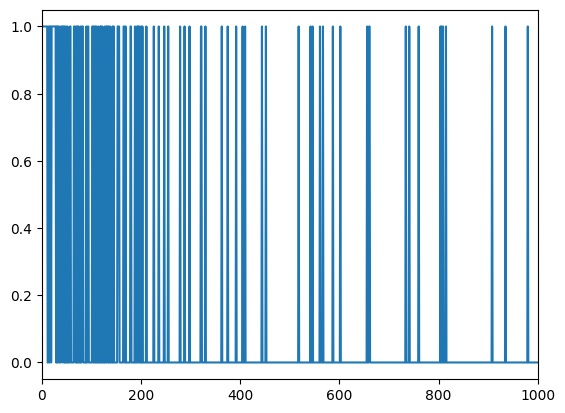

In [368]:
print("'binary' vektörleştirilmiş soru:",
      list(binary_vectorize_layer(first_question).numpy()))

plt.plot(binary_vectorize_layer(first_question).numpy())
plt.xlim(0,1000)

In [369]:
print("'int' vektörleştirilmiş soru:",
      int_vectorize_layer(first_question).numpy())

'int' vektörleştirilmiş soru: [   1  111    6   23  299 1787  198    2 3623  299 7826    1    1  805
 2568   23    1 1218 3892  364 4145    1    1  661   16    5  981   45
  121 1881   47    1  742   36 9987    8 1982  322  662   36   23 2362
  195  543   83 2693 2609  661  144    1  411    2 1371   23  657    1
 6520   84   66    3  166  104   26 1182    6    5    1 1639   44    3
  189 3623  519 1135    1   44 5468  280 1272   71  156  157    5 1759
    9  331    3  227    2 3623  299  115  810    5  547 3833    3    1
 2371  146  202 1195  289    1    6 2179 1787  193    9  136 1195   45
    6   67  181    4   11  198  106    1    1  299   31    1 2216 1924
   29  299   53   28 2081   22   53   42  170  154  256    7   15  453
   28    1  237 2698    1  134 2698  131 2698  323 2698    1    1    1
    1    1    1   23    1 2216 1924   29  299   22   53   42  170  154
  256 1360   15  453   28  237    1  237   68    9  196  807   28 7167
    1  237    1 1364    1  562    1 4406  735 1

In [370]:
print("1289 ---> ", int_vectorize_layer.get_vocabulary()[1289])
print("313 ---> ", int_vectorize_layer.get_vocabulary()[313])
print("Kelime dağarcığı boyutu: {}".format(len(int_vectorize_layer.get_vocabulary())))

1289 --->  roman
313 --->  source
Kelime dağarcığı boyutu: 10000


## Modeli eğit
'Binary' (ikili) olarak vektörize edilmiş veri kümeleri için bir sinir ağı oluşturacağız. Daha sonra, bu sinir ağını eğiteceğiz.

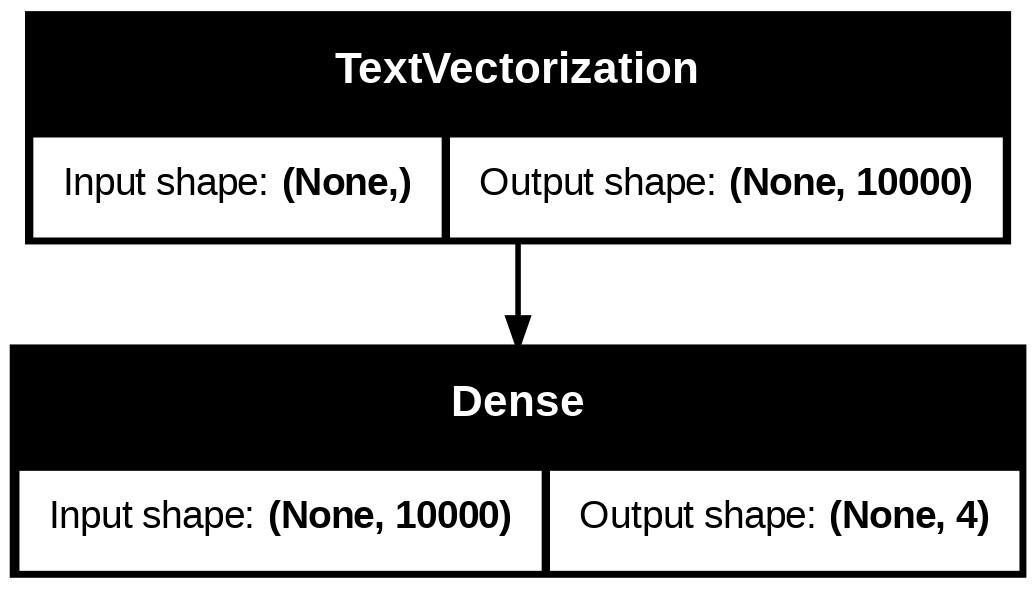

In [371]:
"""
tf.keras.utils.plot_model(binary_model, show_shapes=True)
Yukaridaki kodun calismasinda bir hata ile karsilastim. Bu hatayi 'binary_model.build(input_shape=(None,))' kodu ile cozdum!
"""

binary_model = tf.keras.Sequential([
    binary_vectorize_layer,
    layers.Dense(4)])

binary_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = 'adam',
    metrics = ['accuracy'])

binary_model.build(input_shape=(None,))
tf.keras.utils.plot_model(binary_model, show_shapes=True)

In [372]:
bin_history = binary_model.fit(
    raw_train_ds, validation_data=raw_val_ds, epochs=10)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5212 - loss: 1.2407 - val_accuracy: 0.7781 - val_loss: 0.9139
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8207 - loss: 0.8215 - val_accuracy: 0.8006 - val_loss: 0.7503
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8650 - loss: 0.6531 - val_accuracy: 0.8100 - val_loss: 0.6647
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8873 - loss: 0.5528 - val_accuracy: 0.8231 - val_loss: 0.6112
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9026 - loss: 0.4833 - val_accuracy: 0.8356 - val_loss: 0.5745
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9161 - loss: 0.4310 - val_accuracy: 0.8381 - val_loss: 0.5478
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9266 - loss: 0.3895 - val_accuracy: 0.8406 - val_loss: 0.5277
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9338 - loss: 0.3554 - val_accuracy:

'Binary' veri kümesi için eğitimi tamamladık. Şimdi, 'int' olarak vektörize edilmiş veri kümeleri için bir model oluşturacağım.

In [373]:
"""
create_model fonksiyonu model olusturmak icin kullanacagiz!
- vocab_size: Kelime haznesinin boyutunu belirler (örneğin, 10,000).
- num_labels: Çıkış katmanındaki nöron sayısını belirler (örneğin, ikili sınıflandırma için 1, çok sınıflı sınıflandırma için n).
- vectorizer: Opsiyonel olarak bir TextVectorization katmanı ekleyebilir.
"""

def create_model(vocab_size, num_labels, vectorizer=None):
  my_layers =[]
  if vectorizer is not None:
    my_layers = [vectorizer] # vectorizer modelin input_shape olarakta dusune bilirsiniz

  my_layers.extend([
      layers.Embedding(vocab_size, 64, mask_zero=True), # Kelime gömme katmanı. Kelimeleri 64 boyutlu vektörlere dönüştürür.
      layers.Dropout(0.5), # %50 oranında rastgele nöronları kapatarak aşırı öğrenmeyi (overfitting) önler.
      layers.Conv1D(64, 5, padding="valid", activation="relu", strides=2), # 1D Evrişimsel (Convolutional) Katman.
      layers.GlobalMaxPooling1D(), # Evrişim katmanından gelen çıktıyı tek bir vektöre dönüştürür.
      layers.Dense(num_labels) # Son katman, etiket sayısı kadar nörona sahiptir.
  ])

  model = tf.keras.Sequential(my_layers) # Yukaridaki tum katmanlari bir Sequential model içine eklenir ve model kullanılabilir hale getirilir.
  return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_7' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


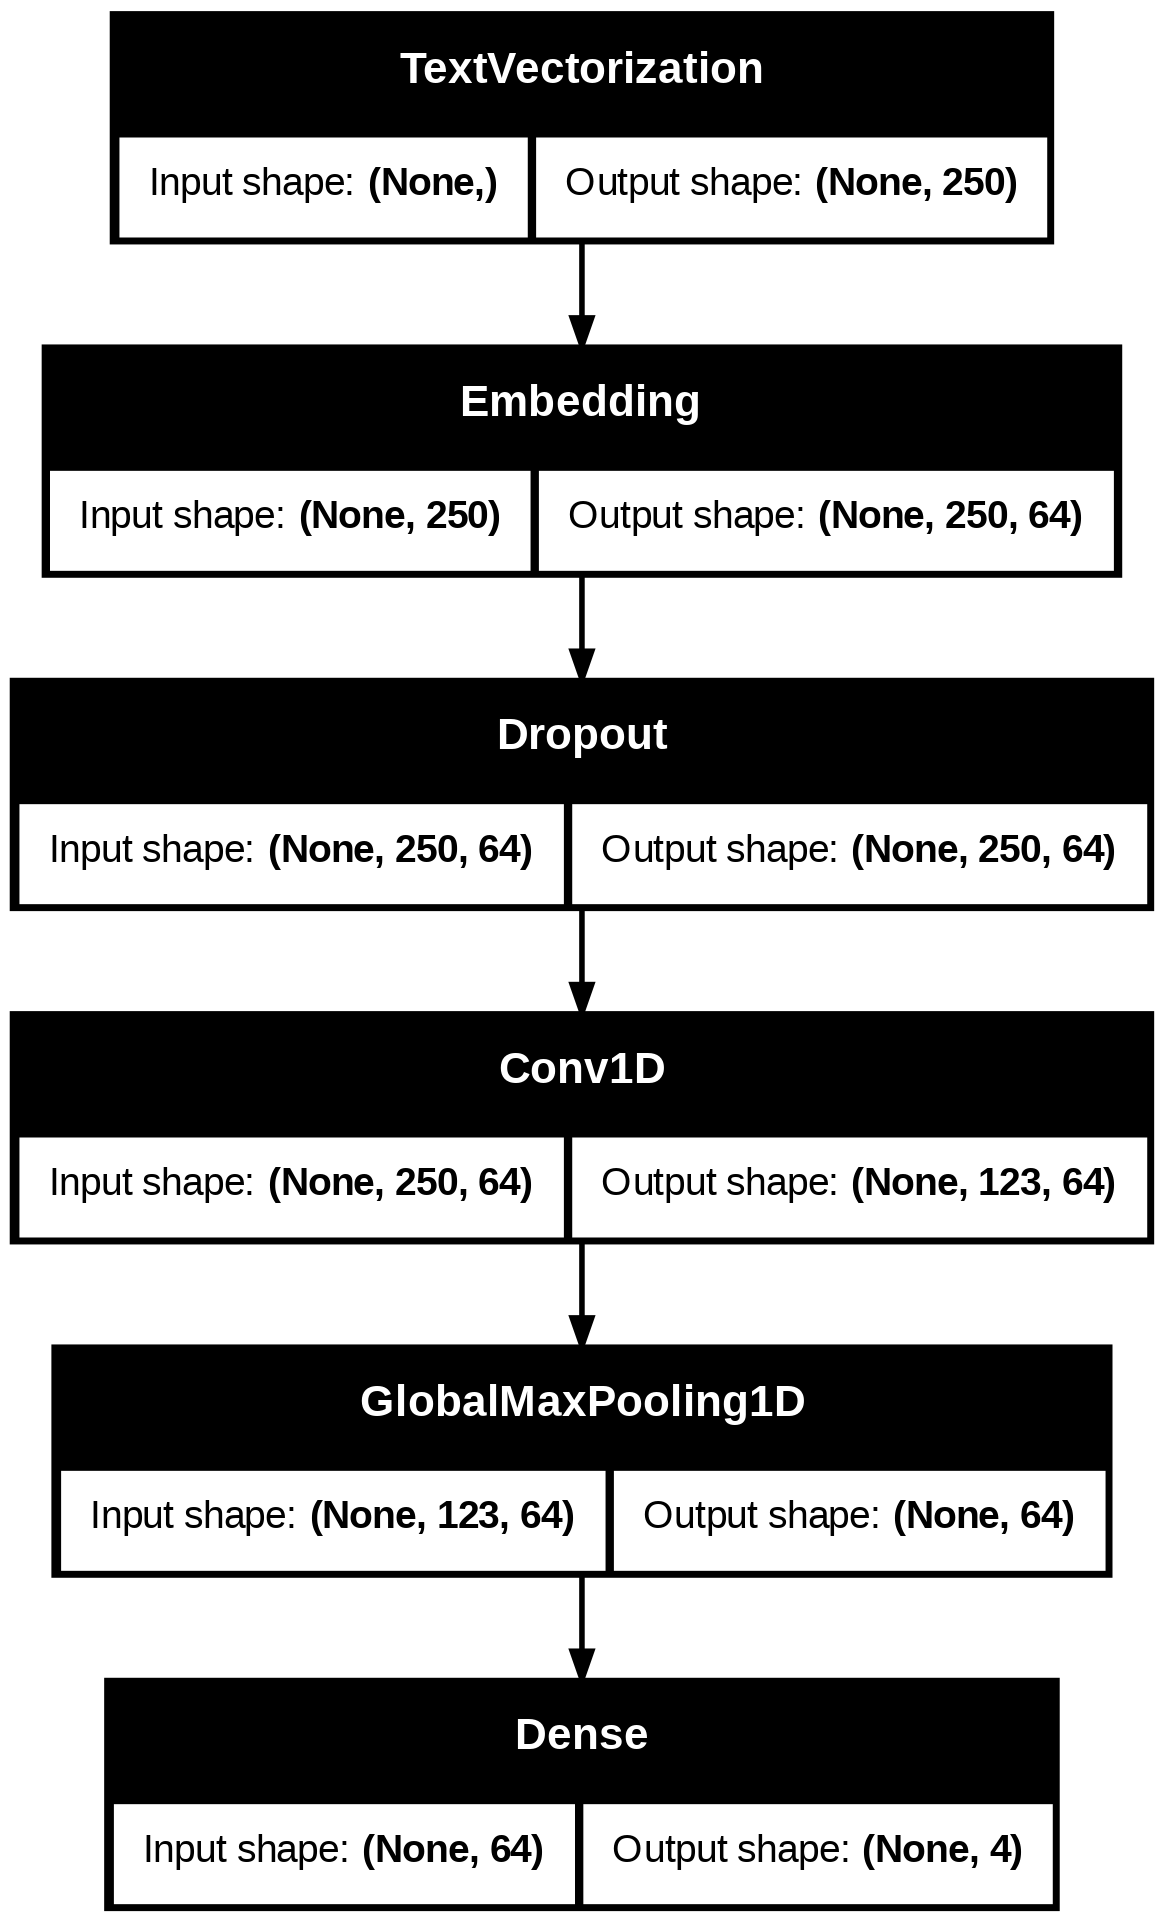

In [374]:
"""
tf.keras.utils.plot_model(int_model, show_shapes=True) yine bu kodda hata aldim!
int_model.build(input_shape=(None,)) kodunu ekleyerek cozdum!

"""
int_model = create_model(vocab_size=VOCAB_SIZE + 1, num_labels = 4, vectorizer=int_vectorize_layer) # 10000 kelimelik bir veri kumesinde 4 sinifli bir problem icin cikti uretecegiz.

int_model.build(input_shape=(None,))

tf.keras.utils.plot_model(int_model, show_shapes=True)

In [375]:
int_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])
int_history = int_model.fit(raw_train_ds, validation_data=raw_val_ds, epochs=10)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_7' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.3338 - loss: 1.3425 - val_accuracy: 0.6194 - val_loss: 0.9049
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6291 - loss: 0.8556 - val_accuracy: 0.7519 - val_loss: 0.6418
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7614 - loss: 0.6072 - val_accuracy: 0.8037 - val_loss: 0.5445
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8490 - loss: 0.4473 - val_accuracy: 0.8094 - val_loss: 0.4972
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8999 - loss: 0.3255 - val_accuracy: 0.8206 - val_loss: 0.4867
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9307 - loss: 0.2337 - val_accuracy: 0.8200 - val_loss: 0.4969
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9543 - loss: 0.1702 - val_accuracy: 0.8131 - val_loss: 0.5188
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9679 - loss: 0.1188 - val_accuracy: 0.811

Text(0, 0.5, 'CE/token')

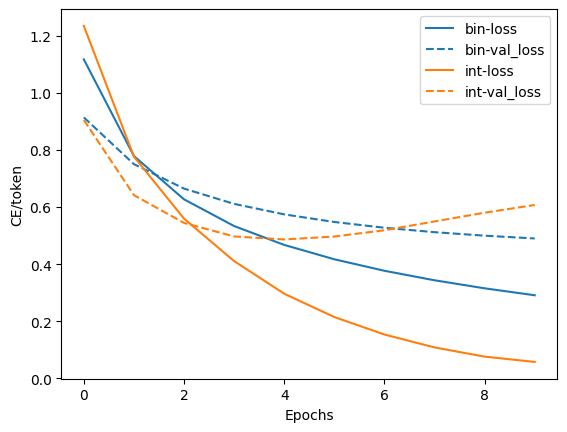

In [376]:
loss = plt.plot(bin_history.epoch, bin_history.history['loss'], label = 'bin-loss')
plt.plot(bin_history.epoch, bin_history.history['val_loss'], '--', color = loss[0].get_color(), label = 'bin-val_loss')

loss = plt.plot(int_history.epoch, int_history.history['loss'], label = 'int-loss')
plt.plot(int_history.epoch, int_history.history['val_loss'], '--', color = loss[0].get_color(), label = 'int-val_loss')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('CE/token')

In [377]:
"""
Veriler, map fonksiyonu kullanılarak işleniyor. Bu işlemde her bir örnek (x, y), x metin verisi ve y etiketidir.
map fonksiyonu, her bir (x, y) çiftini işleyip, yeni bir (vektörleştirilmiş_x, y) çifti döndürüyor.
"""

binary_train_ds = raw_train_ds.map(lambda x,y: (binary_vectorize_layer(x), y))
binary_val_ds = raw_val_ds.map(lambda x,y: (binary_vectorize_layer(x), y))
binary_test_ds = raw_test_ds.map(lambda x,y: (binary_vectorize_layer(x), y))

int_train_ds = raw_train_ds.map(lambda x,y: (int_vectorize_layer(x), y))
int_val_ds = raw_val_ds.map(lambda x,y: (int_vectorize_layer(x), y))
int_test_ds = raw_test_ds.map(lambda x,y: (int_vectorize_layer(x), y))

## Modeli dışa aktar

In [378]:
# Binary modeli kayit ediyorum!
binary_model.export('bin.tf')

Saved artifact at 'bin.tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None,), dtype=tf.string, name='keras_tensor_75')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138593895005072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138593803423952: TensorSpec(shape=(), dtype=tf.int64, name=None)
  138593818380816: TensorSpec(shape=(), dtype=tf.string, name=None)
  138593818383696: TensorSpec(shape=(), dtype=tf.int64, name=None)
  138593753160336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138593896481040: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [379]:
# Kayit edilen modelin tekrar yuklenmesi!
loaded = tf.saved_model.load('bin.tf')

In [380]:
# binary_model.predict(['How do you sort a list?']) HATALI
binary_model.predict(tf.constant(['How do you sort a list?']))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


array([[-0.10239437,  0.0320929 , -0.5995749 ,  0.38328534]],
      dtype=float32)

In [381]:
loaded.serve(tf.constant(['How do you sort a list?'])).numpy()

array([[-0.10239437,  0.0320929 , -0.5995749 ,  0.38328534]],
      dtype=float32)

# Örnek 2: İlyada çevirilerinin yazarını tahmin edin
Bu ornegi gerceklestirmek icin bazi araclar kullanacagiz:
- Dosyalardan metin satırlarını yüklemek için **tf.data.TextLineDataset**'i kullanacaksınız.
- **keras.layers.TextVectorization**'ın kendi versiyonunu şu şekilde uygulayacaksınız:
  - **text.UnicodeScriptTokenizer** - dizeleri belirteçlere dönüştürmek için.
  - **tf.lookup.StaticVocabularyTable** - belirteçleri tam sayı kimliklerine dönüştürmek için.
- Metin işlemeyi veri kümesi işlem hattına yerleştirerek performansı en üst düzeye çıkaracaksınız, böylece model eğitimiyle paralel olarak çalışabilir.

## Veri setini indirin ve inceleyin

In [382]:
# Veri setlerinin indirilmesi
DIRECTORY_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
FILE_NAMES = ['cowper.txt', 'derby.txt', 'butler.txt']

for name in FILE_NAMES:
  text_dir = utils.get_file(name, origin = DIRECTORY_URL + name)

parent_dir = pathlib.Path(text_dir).parent
list(parent_dir.iterdir())

[PosixPath('/root/.keras/datasets/derby.txt'),
 PosixPath('/root/.keras/datasets/butler.txt'),
 PosixPath('/root/.keras/datasets/cowper.txt')]

## Veri setini yükleyin

In [383]:
def labeler(example, index):
  return example, tf.cast(index, tf.int64) # Dosyanın indeksini int64 türüne dönüştürür. TensorFlow'da etiketlerin doğru veri tipinde olması önemlidir.

In [384]:
labeled_data_sets = []

for i, file_name in enumerate(FILE_NAMES):
  lines_dataset = tf.data.TextLineDataset(str(parent_dir / file_name)) # Bu TensorFlow işlevi, verilen dosyadaki her satırı bir veri öğesi olarak okur ve bir tf.data.Dataset objesi döndürür.
  labeled_datasets = lines_dataset.map(lambda ex: labeler(ex, i)) # ex her satırı, i ise dosyanın indeksini temsil eder. Bu fonksiyon her satırı alır ve ona bir etiket ekler.
  labeled_data_sets.append(labeled_datasets)

In [385]:
BUFFER_SIZE = 50000
BATCH_SIZE = 64
VALIDATION_SIZE = 5000

In [386]:
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
  all_labeled_data = all_labeled_data.concatenate(labeled_dataset) # Diger etikete sahip olan verileri 0 etiketine sahip veriler ile birlestirme!

all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False) # Veri setinin karisitirilmesi ve bellekte ne kadar alan kaplayacagini belirleriz

In [387]:
for text, label in all_labeled_data.take(5):
  print('Sentence: ', text.numpy())
  print('label: ', label.numpy())

Sentence:  b'Then Hermes, benefactor of mankind,'
label:  0
Sentence:  b'If ever thou hast heard, hear also now'
label:  0
Sentence:  b'of aegis-bearing Jove? To see the pride of Agamemnon, son of Atreus?'
label:  2
Sentence:  b'Much dust was spread, which, rolling on the earth,'
label:  0
Sentence:  b'Seizes on one, and scatters all the rest;'
label:  1


## Veri setini eğitim için hazırlayın

In [388]:
class MyTokenizer(tf.keras.layers.Layer): # MyTokenizer, TensorFlow'un tf.keras.layers.Layer sınıfını miras alarak özel bir katman oluşturur.
  def __init__(self):
    super().__init__()
    self.tokenizer = tf_text.UnicodeScriptTokenizer() # metni kelime bazında bölmek için kullanılır. Farklı alfabeler ve diller için uygundur.

  def call(self, text):
    lower_case = tf_text.case_fold_utf8(text) # Metni küçük harfe çevirir.
    result = self.tokenizer.tokenize(lower_case) # Metni kelimelere veya Unicode scriptlerine göre ayırır.
    if isinstance(result, tf.RaggedTensor): #tf.RaggedTensor, değişken uzunluktaki dizileri işleyebilen özel bir TensorFlow veri yapısıdır. Eğer sonuç bir RaggedTensor ise, to_tensor() ile düzenli (Dense) bir tensöre çevrilir.
      result = result.to_tensor()
    return result

In [389]:
tokenizer = MyTokenizer()

In [390]:
tokenized_ds = all_labeled_data.map(lambda text, label: (tokenizer(text), label))
tokenized_ds

<_MapDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [391]:
# MyTokenizer sinifinin sonucu gormektesiniz!
for tokens, label in tokenized_ds.take(1):
  break

print(tokens)
print()
print(label)

tf.Tensor([b'then' b'hermes' b',' b'benefactor' b'of' b'mankind' b','], shape=(7,), dtype=string)

tf.Tensor(0, shape=(), dtype=int64)


In [392]:
tokenized_ds = tokenized_ds.cache().prefetch(tf.data.AUTOTUNE)

vocab_count = collections.Counter()
for toks, labels in tokenized_ds.ragged_batch(1000):
  toks = tf.reshape(toks, [-1])
  for tok in toks.numpy():
    vocab_count[tok] += 1

vocab = [tok for tok, count in vocab_count.most_common(VOCAB_SIZE)]

print('En sık kullanilan ilk bes kelime: ', vocab[:5])

En sık kullanilan ilk bes kelime:  [b',', b'the', b'and', b"'", b'of']


In [393]:
class MyVocabTable(tf.keras.layers.Layer):
  def __init__(self, vocab):
    super().__init__()
    self.keys = [''] + vocab
    self.values = range(len(self.keys))

    self.init = tf.lookup.KeyValueTensorInitializer(self.keys, self.values, key_dtype = tf.string, value_dtype = tf.int64) # Kelime → İndeks dönüşümü için bir başlangıç tablosu oluşturur.

    num_oov_buckets = 1 # Sözlükte olmayan kelimeler için 1 ek "Out of Vocabulary" (OOV) bölmesi oluşturur.
    self.table = tf.lookup.StaticVocabularyTable(self.init, num_oov_buckets) #  Kelime → Sayı eşlemesini içeren statik bir tablo oluşturur.

  def call(self, x):
    result = self.table.lookup(x) # Girdi kelimeleri indekslere çevirir.
    return result

In [394]:
vocab_table = MyVocabTable(['a', 'b', 'c'])
vocab_table(tf.constant([''] + list('abcdefghi')))

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 2, 3, 4, 4, 4, 4, 4, 4])>

In [395]:
vocab_table = MyVocabTable(vocab)

In [396]:
# Modelin iki layer'i burada belli oldu!
#preprocess_text = tf.keras.Sequential([
#    tokenizer,
#    vocab_table
#])

def preprocess_text(text):
  tokenize_text = tokenizer(text)
  vocab_text = vocab_table(tokenize_text)
  return vocab_text

In [397]:
example_text, example_label = next(iter(all_labeled_data))
print("Sentence: ", example_text.numpy())
vectorized_text = preprocess_text(example_text)
print("Vectorized sentence: ", vectorized_text.numpy())

Sentence:  b'Then Hermes, benefactor of mankind,'
Vectorized sentence:  [  32 1630    1 7805    5 1307    1]


In [398]:
all_encoded_data = all_labeled_data.map(lambda text, label: (preprocess_text(text), label))

for ids, label in all_encoded_data.take(1):
  break

print("Ids: ", ids.numpy())
print("Label: ", label.numpy())

Ids:  [  32 1630    1 7805    5 1307    1]
Label:  0


## Veri setini eğitim ve test setlerine ayırın

In [399]:
train_data = all_encoded_data.skip(VALIDATION_SIZE).shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
"""
skip(VALIDATION_SIZE) → VALIDATION_SIZE kadar veriyi atlayarak kalan kısmı eğitim kümesi olarak alır.
shuffle(BUFFER_SIZE) → Verileri rastgele karıştırır (shuffle), böylece modelin öğrenme süreci daha dengeli olur.
padded_batch(BATCH_SIZE) → Verileri sabit uzunlukta olacak şekilde doldurarak (padding) batch'lere ayırır. Çünkü dizilerin uzunlukları farklı olabilir.
"""
validation_data = all_encoded_data.take(VALIDATION_SIZE).padded_batch(BATCH_SIZE)
"""
take(VALIDATION_SIZE) → İlk VALIDATION_SIZE kadar veriyi alarak doğrulama kümesi olarak ayırır.
padded_batch(BATCH_SIZE) → Verileri sabit uzunlukta olacak şekilde padding yaparak batch’lere ayırır.
"""

'\ntake(VALIDATION_SIZE) → İlk VALIDATION_SIZE kadar veriyi alarak doğrulama kümesi olarak ayırır.\npadded_batch(BATCH_SIZE) → Verileri sabit uzunlukta olacak şekilde padding yaparak batch’lere ayırır.\n'

In [400]:
sample_text, sample_labels = next(iter(validation_data))
print('Text shape: ', sample_text.shape)
print('Label shape: ', sample_labels.shape)
print('Ilk text ornegi: ', sample_text[0])
print('Ilk label ornegi: ', sample_labels[0])

Text shape:  (64, 17)
Label shape:  (64,)
Ilk text ornegi:  tf.Tensor(
[  32 1630    1 7805    5 1307    1    0    0    0    0    0    0    0
    0    0    0], shape=(17,), dtype=int64)
Ilk label ornegi:  tf.Tensor(0, shape=(), dtype=int64)


In [401]:
train_data = train_data.prefetch(tf.data.AUTOTUNE)
validation_data = validation_data.prefetch(tf.data.AUTOTUNE)
"""
prefetch(buffer_size=tf.data.AUTOTUNE): TensorFlow'un veri yükleme sürecini optimize etmesine olanak tanır.
Amaç: Model eğitimi sırasında CPU ve GPU’nun aynı anda çalışmasını sağlamak.
Nasıl çalışır?
  Model bir batch üzerinde işlem yaparken, bir sonraki batch arka planda hazırlanır.
  Böylece veri yükleme gecikmeleri azalır ve eğitim süreci hızlanır.
"""

"\nprefetch(buffer_size=tf.data.AUTOTUNE): TensorFlow'un veri yükleme sürecini optimize etmesine olanak tanır.\nAmaç: Model eğitimi sırasında CPU ve GPU’nun aynı anda çalışmasını sağlamak.\nNasıl çalışır?\n  Model bir batch üzerinde işlem yaparken, bir sonraki batch arka planda hazırlanır.\n  Böylece veri yükleme gecikmeleri azalır ve eğitim süreci hızlanır.\n"

## Modeli eğit

In [402]:
model = create_model(vocab_size=VOCAB_SIZE + 2, num_labels = 3)
model.compile(
    optimizer = 'adam',
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_8' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


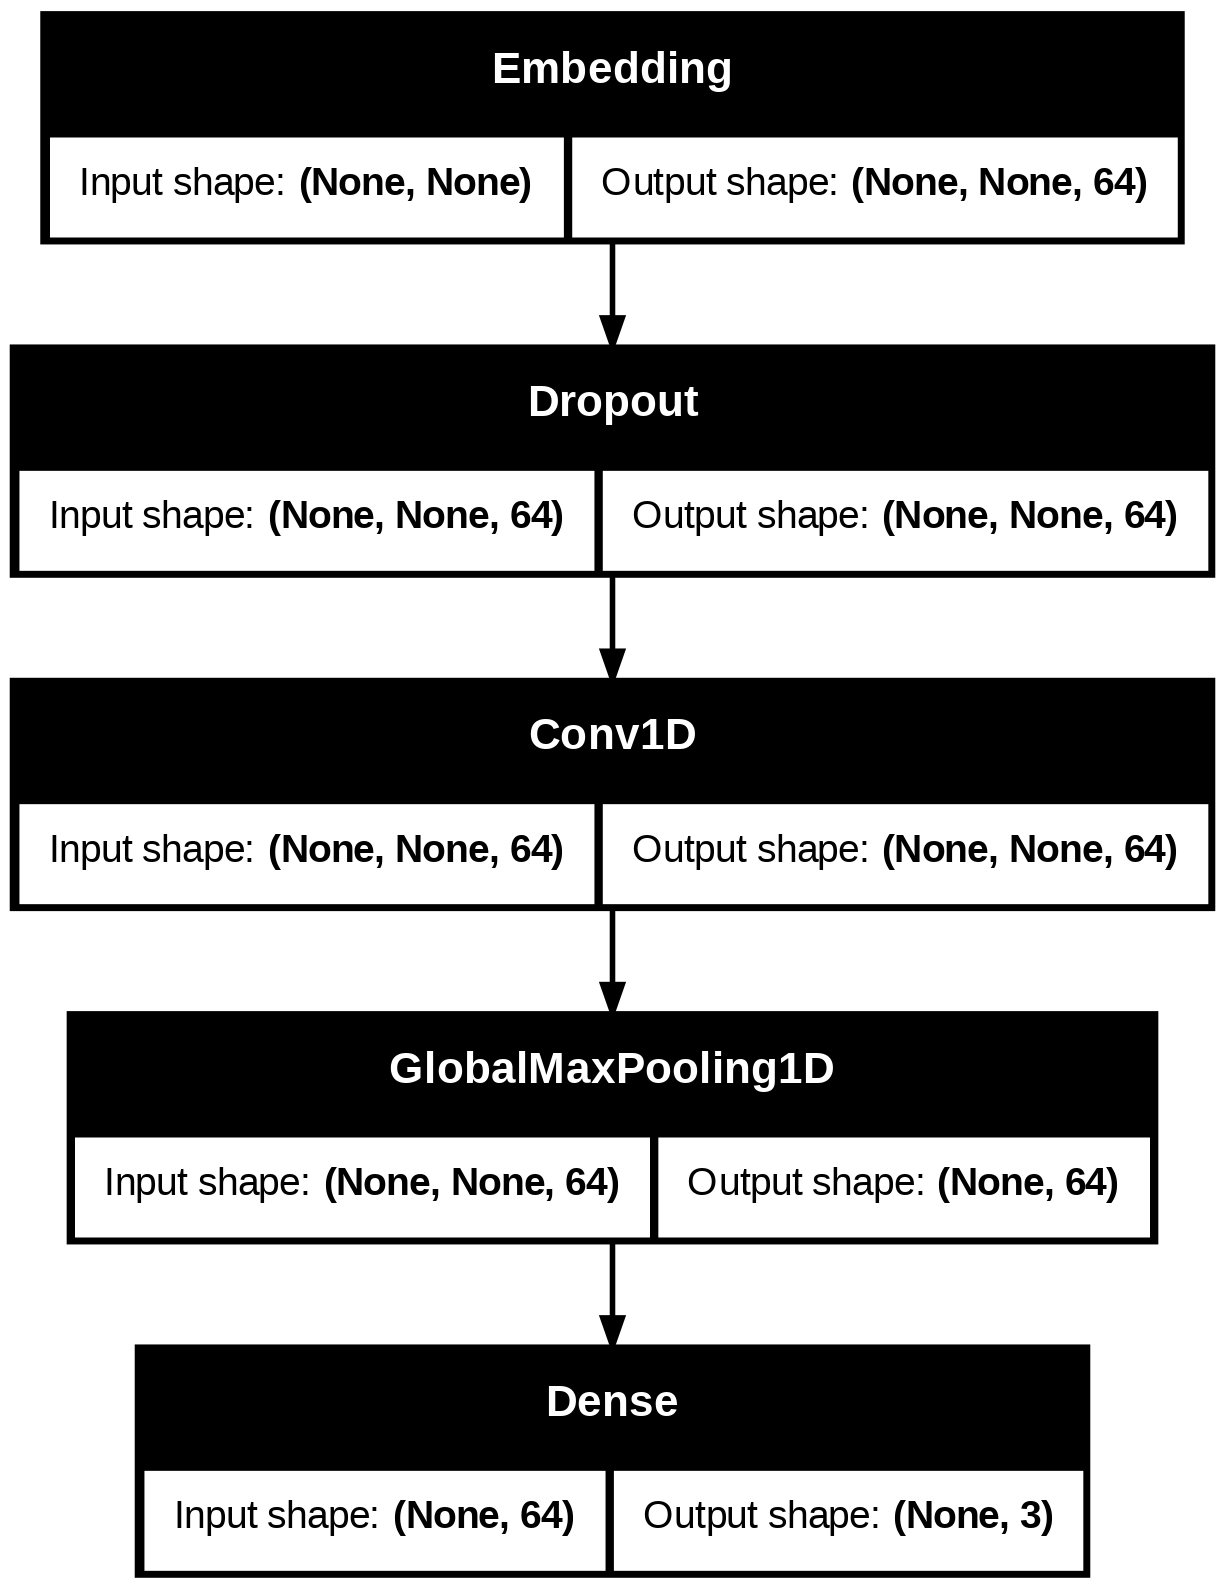

In [403]:
model.build(input_shape=(None,None))

tf.keras.utils.plot_model(model, show_shapes=True)

In [404]:
history = model.fit(train_data, validation_data = validation_data, epochs = 3)

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_8' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    693/Unknown 47s 9ms/step - accuracy: 0.6178 - loss: 0.7618

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


697/697 ━━━━━━━━━━━━━━━━━━━━ 51s 14ms/step - accuracy: 0.6186 - loss: 0.7606 - val_accuracy: 0.8238 - val_loss: 0.4055
Epoch 2/3
697/697 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.8529 - loss: 0.3644 - val_accuracy: 0.8454 - val_loss: 0.3733
Epoch 3/3
697/697 ━━━━━━━━━━━━━━━━━━━━ 34s 12ms/step - accuracy: 0.8868 - loss: 0.2861 - val_accuracy: 0.8466 - val_loss: 0.3634


In [405]:
metrics= model.evaluate(validation_data, return_dict = True)

print('Loss(Hata): ', metrics['loss'])
print('Accuracy(Dogruluk): {:2.2%}'.format(metrics['accuracy']))

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8418 - loss: 0.3620
Loss(Hata):  0.36343806982040405
Accuracy(Dogruluk): 84.66%


## Modeli dışa aktar

In [406]:
tf.saved_model.save(model, 'my_model.tf')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_8' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_8' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [407]:
loaded = tf.saved_model.load('my_model.tf')

In [408]:
sample_text = tf.constant(['The field bristled with the long and deadly spears which they bore.']) # Ornek metinimiz
sample_text = preprocess_text(sample_text) # metini modele vermek icin tokenlerine ayiriyoruz!
model.predict(sample_text) # metinin sinifi tahmin etmeye calsiyoruz.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_8' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


array([[-3.3172803 ,  0.18940806,  3.5277798 ]], dtype=float32)

In [409]:
list(sample_text.numpy()[0])

[2, 228, 6192, 13, 2, 169, 3, 1125, 365, 72, 26, 224, 6]

In [410]:
# Doğru çağırma yöntemi
sample_text = tf.constant([list(sample_text.numpy()[0])], dtype=tf.float32) # Loaded ile yukledigimiz model icin sample_text'in tipini float olarak digitiriyoruz!
infer = loaded.signatures["serving_default"] # loaded.signatures["serving_default"], TensorFlow'un kaydedilen modelinin varsayılan "serving" fonksiyonunu alır. Bu fonksiyon, modelin çalıştırılmasını sağlar.
infer(sample_text)

{'output_0': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-3.3172803 ,  0.18940806,  3.5277798 ]], dtype=float32)>}

# TensorFlow Veri Kümeleri'ni (TFDS) kullanarak daha fazla veri kümesi indirin

In [411]:
train_ds = tfds.load('imdb_reviews',
                     split = 'train[:80%]',
                     batch_size = BATCH_SIZE,
                     shuffle_files = True,
                     as_supervised = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.EOO7RN_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.EOO7RN_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.EOO7RN_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [413]:
val_ds = tfds.load(
    'imdb_reviews',
    split = 'train[80%:]',
    batch_size = BATCH_SIZE,
    shuffle_files = True,
    as_supervised = True
)

tfds kütüphanesini kullanarak imdb_reviews veri setini indiriyoruz. Bu veri setini %80 eğitim (train) ve %20 doğrulama (validation) verileri olarak bölüyoruz!

In [414]:
for review_batch, label_batch in val_ds.take(1):
  for i in range(5):
    print('Review: ', review_batch[i].numpy())
    print('Label: ', label_batch[i].numpy())

Review:  b"Instead, go to the zoo, buy some peanuts and feed 'em to the monkeys. Monkeys are funny. People with amnesia who don't say much, just sit there with vacant eyes are not all that funny.<br /><br />Black comedy? There isn't a black person in it, and there isn't one funny thing in it either.<br /><br />Walmart buys these things up somehow and puts them on their dollar rack. It's labeled Unrated. I think they took out the topless scene. They may have taken out other stuff too, who knows? All we know is that whatever they took out, isn't there any more.<br /><br />The acting seemed OK to me. There's a lot of unfathomables tho. It's supposed to be a city? It's supposed to be a big lake? If it's so hot in the church people are fanning themselves, why are they all wearing coats?"
Label:  0
Review:  b'Well, was Morgan Freeman any more unusual as God than George Burns? This film sure was better than that bore, "Oh, God". I was totally engrossed and LMAO all the way through. Carrey was

## Veri setini eğitim için hazırlayı

In [416]:
vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

train_text = train_ds.map(lambda text, labels: text)
vectorize_layer.adapt(train_text)

In [418]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [419]:
train_ds = train_ds.map(vectorize_text)
val_ds = val_ds.map(vectorize_text)

In [420]:
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

## Modeli oluşturun, yapılandırın ve eğitin

In [423]:
model = create_model(vocab_size=VOCAB_SIZE, num_labels=1)

model.build(input_shape = (None,None))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_11' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)             │ (None, None, 64)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, None, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, None, 64)            │          20,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_11              │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 660,609 (2.52 MB)

 Trainable params: 660,609 (2.52 MB)

 Non-trainable params: 0 (0.00 B)

In [424]:
model.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

In [425]:
history = model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.5241 - loss: 0.6676 - val_accuracy: 0.7884 - val_loss: 0.4391
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8116 - loss: 0.4140 - val_accuracy: 0.8402 - val_loss: 0.3486
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.8664 - loss: 0.3076 - val_accuracy: 0.8544 - val_loss: 0.3250


In [426]:
loss, accuracy = model.evaluate(val_ds)

print("Loss: ", loss)
print("Accuracy: {:2.2%}".format(accuracy))

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8563 - loss: 0.3290
Loss:  0.3250124454498291
Accuracy: 85.44%


## Modeli dışa aktar

In [431]:
export_model = tf.keras.Sequential(
    [vectorize_layer, model,
     layers.Activation('sigmoid')])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

In [433]:
import numpy as np

inputs = [
    "This is a fantastic movie.",
    "This is a bad movie.",
    "This movie was so bad that it was good.",
    "I will never say yes to watching this movie.",
]
inputs = tf.constant(inputs) # Bu kod olmadan predict islemini gerceklestiremiyoruz!
predicted_scores = export_model.predict(inputs)
predicted_labels = [int(round(x[0])) for x in predicted_scores]

for input, label in zip(inputs, predicted_labels):
  print("Question: ", input)
  print("Predicted label: ", label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
Question:  tf.Tensor(b'This is a fantastic movie.', shape=(), dtype=string)
Predicted label:  1
Question:  tf.Tensor(b'This is a bad movie.', shape=(), dtype=string)
Predicted label:  0
Question:  tf.Tensor(b'This movie was so bad that it was good.', shape=(), dtype=string)
Predicted label:  0
Question:  tf.Tensor(b'I will never say yes to watching this movie.', shape=(), dtype=string)
Predicted label:  0


# Sonuc
Load Text bölümünün sonuna geldik. Bu bölümde, metin veri setlerinin indirilmesi, tokenize edilmesi, ikili ve çoklu etiketlere dönüştürülmesi işlemlerini gördük. Eğitimini gerçekleştirdiğimiz modellerin kaydedilmesi ve yeniden yüklenmesini de inceledik. Bu projeyi, TensorFlow kütüphanesini daha iyi anlamak ve pratik yapmak amacıyla hazırlamaya devam edeceğim. Bu projelere benzer ve bu projelerin üzerine birçok yeni proje gelecektir. Umarım bu çalışmam sizler için faydalı olmuştur. Eğer herhangi bir sorunuz olursa, aşağıdaki linklerden bana ulaşabilirsiniz. İyi çalışmalar dilerim!

[Linkedin](https://www.linkedin.com/in/ihsancenkiz/)<br>
[Github](https://github.com/ihsncnkz)<br>
[Kaggle](https://www.kaggle.com/ihsncnkz)